### Import library

In [1]:
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as trasnforms
from torchvision.models import resnet34

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
from PIL import Image

### Set seed

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


set_seed(1998)

### Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_normal_dir = '/content/drive/MyDrive/image_processing_project/train/NORMAL'
train_pneumonia_dir = '/content/drive/MyDrive/image_processing_project/train/PNEUMONIA'
valid_normal_dir = '/content/drive/MyDrive/image_processing_project/valid/NORMAL'
valid_pneumonia_dir = '/content/drive/MyDrive/image_processing_project/valid/PNEUMONIA'

train_normal_filenames = sorted([os.path.join(train_normal_dir, f) for f in os.listdir(train_normal_dir)])
train_pneumonia_filenames = sorted([os.path.join(train_pneumonia_dir, f) for f in os.listdir(train_pneumonia_dir)])
valid_normal_filenames = sorted([os.path.join(valid_normal_dir, f) for f in os.listdir(valid_normal_dir)])
valid_pneumonia_filenames = sorted([os.path.join(valid_pneumonia_dir, f) for f in os.listdir(valid_pneumonia_dir)])

train_filenames = [*train_normal_filenames, *train_pneumonia_filenames]
valid_filenames = [*valid_normal_filenames, *valid_pneumonia_filenames]

print(len(train_filenames))

5216


In [5]:
train_transforms = A.Compose([A.Resize(height=256, width=256),
                              A.CLAHE(always_apply=True, p=1.0, clip_limit=(4, 4), tile_grid_size=(4, 4)),
                              A.Normalize(mean=[0.5], std=[0.5], max_pixel_value=255.0, p=1.0),
                              ToTensorV2(always_apply=True),])
valid_transforms = A.Compose([A.Resize(height=256, width=256),
                              A.CLAHE(always_apply=True, p=1.0, clip_limit=(4, 4), tile_grid_size=(4, 4)),
                              A.Normalize(mean=[0.5], std=[0.5], max_pixel_value=255.0, p=1.0),
                              ToTensorV2(always_apply=True),])

In [6]:
class XrayDataset(Dataset):
    def __init__(self, filenames, transforms):
        self.filenames = filenames
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        img = Image.open(img_path)
        if img.mode == "RGB":
            img = img.convert("L")
        img = np.array(img)
        transformed_img = self.transforms(image=img)["image"]
        label = 0 if "IM" in img_path else 1
        return transformed_img, label

In [7]:
train_dataset = XrayDataset(train_filenames, train_transforms)
valid_dataset = XrayDataset(valid_filenames, valid_transforms)

train_size = round(len(train_dataset)*0.8)
valid_size = len(train_dataset) - train_size

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset,
                          batch_size=64,
                          num_workers=2,
                          shuffle=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=64,
                          num_workers=2,
                          shuffle=False)

### Load model

In [8]:
class ResNet34(nn.Module):
    def __init__(self, num_classes):
        super(ResNet34, self).__init__()
        self.model = resnet34(weights="DEFAULT")
        self.num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(self.num_ftrs, num_classes)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)

    def forward(self, x):
        x = self.model(x)
        return x

In [9]:
model = ResNet34(num_classes=2)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

cuda:0


### Test

In [11]:
test_normal_dir = '/content/drive/MyDrive/image_processing_project/test/NORMAL'
test_pneumonia_dir = '/content/drive/MyDrive/image_processing_project/test/PNEUMONIA'

test_normal_filenames = sorted([os.path.join(test_normal_dir, f) for f in os.listdir(test_normal_dir)])
test_pneumonia_filenames = sorted([os.path.join(test_pneumonia_dir, f) for f in os.listdir(test_pneumonia_dir)])

test_filenames = [*test_normal_filenames, *test_pneumonia_filenames]

In [12]:
test_transforms = A.Compose([A.Resize(height=256, width=256),
                             A.CLAHE(always_apply=False, p=1.0, clip_limit=(4, 4), tile_grid_size=(4, 4)),
                             A.Normalize(mean=[0.5], std=[0.5], max_pixel_value=255.0, p=1.0),
                             ToTensorV2(always_apply=True),])

In [13]:
class XrayInferenceDataset(Dataset):
    def __init__(self, filenames, transforms):
        self.filenames = filenames
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        img = Image.open(img_path)
        if img.mode == "RGB":
            img = img.convert("L")
        img = np.array(img)
        transformed_img = self.transforms(image=img)["image"]
        img_name = img_path.split("/")[-1]
        return transformed_img, img_name

In [14]:
test_dataset = XrayDataset(valid_filenames, transforms=test_transforms)
print(len(test_dataset))

test_loader = DataLoader(valid_dataset,
                          batch_size=64,
                          num_workers=2,
                          shuffle=False)

624


In [15]:
def inference(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        total_samples = 0
        true_positives = 0
        true_negatives = 0
        false_positives = 0
        false_negatives = 0

        for batch_in, batch_out in test_loader:
            batch_in = batch_in.to(device)

            y_pred = model(batch_in)
            y_pred = F.softmax(y_pred, dim=1)
            _, preds = torch.max(y_pred, 1)

            batch_size = batch_in.size(0)
            total_samples += batch_size

            preds = preds.to('cpu')

            true_positives += ((preds == 1) & (batch_out == 1)).sum().item()
            true_negatives += ((preds == 0) & (batch_out == 0)).sum().item()
            false_positives += ((preds == 1) & (batch_out == 0)).sum().item()
            false_negatives += ((preds == 0) & (batch_out == 1)).sum().item()

        accuracy = (true_positives + true_negatives) / total_samples
        recall = true_positives / (true_positives + false_negatives)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Recall: {recall:.4f}")


model = torch.load("/content/drive/MyDrive/image_processing_project/model_cl.pt")
model.to(device)
inference(model, test_loader, device)

Accuracy: 0.9789
Recall: 0.9883


In [16]:
import torch
import torch.nn.functional as F

def weighted_inference(model, test_loader, device, weight):
    model.eval()
    with torch.no_grad():
        total_samples = 0
        true_positives = 0
        true_negatives = 0
        false_positives = 0
        false_negatives = 0

        for batch_in, batch_out in test_loader:
            batch_in = batch_in.to(device)

            y_pred = model(batch_in)
            y_pred = F.softmax(y_pred, dim=1)
            y_pred[:, 1] += weight
            _, preds = torch.max(y_pred, 1)

            batch_size = batch_in.size(0)
            total_samples += batch_size

            preds = preds.to('cpu')

            true_positives += ((preds == 1) & (batch_out == 1)).sum().item()
            true_negatives += ((preds == 0) & (batch_out == 0)).sum().item()
            false_positives += ((preds == 1) & (batch_out == 0)).sum().item()
            false_negatives += ((preds == 0) & (batch_out == 1)).sum().item()

        accuracy = (true_positives + true_negatives) / total_samples
        recall = true_positives / (true_positives + false_negatives)
        precision = true_positives / (true_positives + false_positives)

        # Calculate F1 score
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print("-" * 40)
        print(f"Weight: {weight}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print("-" * 40)

        return accuracy, recall, f1_score

model = torch.load("/content/drive/MyDrive/image_processing_project/model_cl.pt")
model.to(device)

accuracy_list = []
recall_list = []
f1_score_list = []

weight_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for weight in weight_list:
    accuracy, recall, f1_score = weighted_inference(model, test_loader, device, weight=weight)
    accuracy_list.append(accuracy)
    recall_list.append(recall)
    f1_score_list.append(f1_score)

----------------------------------------
Weight: 0
Accuracy: 0.9789
Precision: 0.9832
Recall: 0.9883
F1 Score: 0.9858
----------------------------------------
----------------------------------------
Weight: 0.1
Accuracy: 0.9760
Precision: 0.9794
Recall: 0.9883
F1 Score: 0.9838
----------------------------------------
----------------------------------------
Weight: 0.2
Accuracy: 0.9751
Precision: 0.9781
Recall: 0.9883
F1 Score: 0.9832
----------------------------------------
----------------------------------------
Weight: 0.3
Accuracy: 0.9722
Precision: 0.9744
Recall: 0.9883
F1 Score: 0.9813
----------------------------------------
----------------------------------------
Weight: 0.4
Accuracy: 0.9732
Precision: 0.9744
Recall: 0.9896
F1 Score: 0.9820
----------------------------------------
----------------------------------------
Weight: 0.5
Accuracy: 0.9732
Precision: 0.9744
Recall: 0.9896
F1 Score: 0.9820
----------------------------------------
------------------------------------

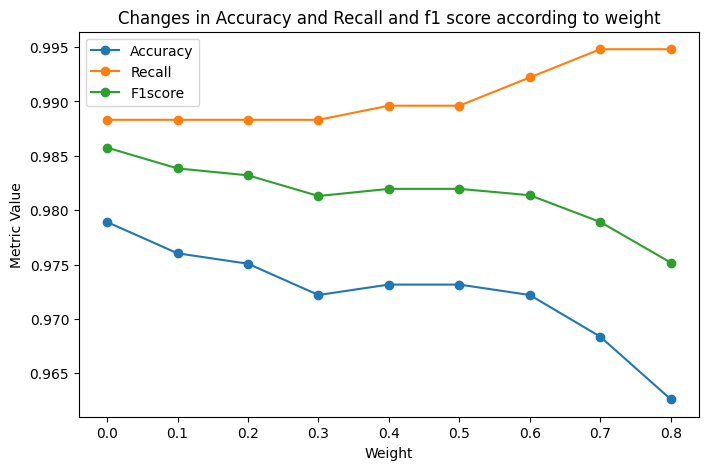

In [17]:
import matplotlib.pyplot as plt

accuracy = [acc for acc in accuracy_list]
recall = [rec for rec in recall_list]
f1score = [f1 for f1 in f1_score_list]
weight_list = [weight for weight in weight_list]

plt.figure(figsize=(8, 5))
plt.plot(weight_list, accuracy, label='Accuracy', marker='o')
plt.plot(weight_list, recall, label='Recall', marker='o')
plt.plot(weight_list, f1score, label='F1score', marker='o')

plt.xlabel('Weight')
plt.ylabel('Metric Value')
plt.title('Changes in Accuracy and Recall and f1 score according to weight')
plt.xticks(weight_list)
plt.legend()

plt.show()